In [26]:
#  Kütüphaneler
import numpy as np
import pandas as pd
import matplotlib. pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn. metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.datasets import fetch_rcv1
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')



In [27]:
#  HIGGS Verisini Yükle
print("HIGGS verisi yükleniyor...")

# CSV dosyasını oku
df = pd. read_csv("HIGGS.csv", header=None, nrows=30000)
data = df.to_numpy()

# X ve y ayır (ilk sütun etiket)
y_full = data[:, 0]. astype(int)
X_full = data[:, 1:]

# 20000 örnek seç
X_subset, _, y_subset, _ = train_test_split(
    X_full, y_full, train_size=20000, stratify=y_full, random_state=22
)

# Normalizasyon (manuel)
ortalama = np.mean(X_subset, axis=0)
std_sapma = np.std(X_subset, axis=0)
std_sapma[std_sapma == 0] = 1
X_scaled = (X_subset - ortalama) / std_sapma

# Train-Test ayır
X_train_higgs, X_test_higgs, y_train_higgs, y_test_higgs = train_test_split(
    X_scaled, y_subset, test_size=0.2, random_state=22, stratify=y_subset
)

# Validation seti ayır
X_train_h, X_val_h, y_train_h, y_val_h = train_test_split(
    X_train_higgs, y_train_higgs, test_size=0.2, random_state=22
)

# y'leri (N,1) formatına çevir
y_train_h = y_train_h. reshape(-1, 1)
y_val_h = y_val_h. reshape(-1, 1)
y_test_higgs = y_test_higgs.reshape(-1, 1)

print("HIGGS verisi hazır!")
print("Train:", X_train_h.shape)
print("Val:", X_val_h.shape)
print("Test:", X_test_higgs.shape)

HIGGS verisi yükleniyor...
HIGGS verisi hazır!
Train: (12800, 28)
Val: (3200, 28)
Test: (4000, 28)


In [28]:
# RCV1 Verisini Yükle
print("RCV1 verisi yükleniyor...")

rcv1 = fetch_rcv1()
X_rcv1_full = rcv1.data
y_rcv1_all = rcv1.target

# CCAT kategorisi için etiket al
ccat_index = np.where(rcv1.target_names == 'CCAT')[0][0]
y_binary = y_rcv1_all[:, ccat_index]. toarray().ravel()

# Karıştır ve 10000 örnek seç
X_shuf, y_shuf = shuffle(X_rcv1_full, y_binary, random_state=22)
X_subset_rcv1 = X_shuf[:10000]
y_subset_rcv1 = y_shuf[:10000]

# TF-IDF uygula
tfidf = TfidfTransformer(norm='l2', use_idf=True)
X_tfidf = tfidf.fit_transform(X_subset_rcv1)

# Train-Test ayır
X_train_rcv1, X_test_rcv1, y_train_rcv1, y_test_rcv1 = train_test_split(
    X_tfidf, y_subset_rcv1, test_size=0.2, random_state=22, stratify=y_subset_rcv1
)

# Validation seti ayır
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(
    X_train_rcv1, y_train_rcv1, test_size=0.2, random_state=22
)

print("RCV1 verisi hazır!")
print("Train:", X_train_r.shape)
print("Val:", X_val_r.shape)
print("Test:", X_test_rcv1.shape)
print("NOT:  RCV1 sparse matrix formatında!")

RCV1 verisi yükleniyor...
RCV1 verisi hazır!
Train: (6400, 47236)
Val: (1600, 47236)
Test: (2000, 47236)
NOT:  RCV1 sparse matrix formatında!


In [29]:
#  Aktivasyon Fonksiyonları
def sigmoid(z):
    """Sigmoid fonksiyonu:  1 / (1 + e^-z)"""
    z = np.clip(z, -500, 500)  # overflow önle
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_turev(z):
    """Sigmoid türevi:  sigmoid(z) * (1 - sigmoid(z))"""
    s = sigmoid(z)
    return s * (1 - s)

def tanh(z):
    """Tanh fonksiyonu"""
    return np.tanh(z)

def tanh_turev(z):
    """Tanh türevi: 1 - tanh(z)^2"""
    return 1 - np.tanh(z) ** 2

def relu(z):
    """ReLU fonksiyonu:  max(0, z)"""
    return np.maximum(0, z)

def relu_turev(z):
    """ReLU türevi: 1 if z > 0 else 0"""
    return (z > 0).astype(float)

print("Aktivasyon fonksiyonları tanımlandi!")

Aktivasyon fonksiyonları tanımlandi!


In [31]:
#  Binary Cross Entropy Loss
def bce_loss(y_true, y_pred):
    """
    Binary Cross Entropy hesapla
    Formül: -1/N * sum(y*log(p) + (1-y)*log(1-p))
    """
    eps = 1e-15  # log(0) önlemek için
    y_pred = np.clip(y_pred, eps, 1 - eps)
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

print("Loss fonksiyonu tanımlandı!")

Loss fonksiyonu tanımlandı!


In [32]:
#  Basit MLP Sınıfı (2 Gizli Katman)
class MLP:
    
    
    def __init__(self, input_boyut, hidden1_boyut, hidden2_boyut, 
                 aktivasyon='relu', optimizer='adam', lr=0.01):
        """
        Parametreler:
        - input_boyut:  Giris ozellik sayisi
        - hidden1_boyut: 1. gizli katman noron sayisi
        - hidden2_boyut: 2. gizli katman noron sayisi
        - aktivasyon:  'relu', 'sigmoid' veya 'tanh'
        - optimizer: 'sgd', 'momentum', 'rmsprop' veya 'adam'
        - lr: ogrenme orani
        """
        np.random.seed(42)
        
        self.lr = lr
        self.optimizer = optimizer
        self.aktivasyon = aktivasyon
        
        # Aktivasyon fonksiyonunu sec
        if aktivasyon == 'relu':
            self. act = relu
            self.act_turev = relu_turev
        elif aktivasyon == 'sigmoid':
            self.act = sigmoid
            self.act_turev = sigmoid_turev
        elif aktivasyon == 'tanh': 
            self.act = tanh
            self.act_turev = tanh_turev
        
        # Agirliklari başlat (He initialization)
        self.W1 = np. random.randn(input_boyut, hidden1_boyut) * np.sqrt(2.0 / input_boyut)
        self.b1 = np.zeros((1, hidden1_boyut))
        
        self.W2 = np.random.randn(hidden1_boyut, hidden2_boyut) * np.sqrt(2.0 / hidden1_boyut)
        self.b2 = np.zeros((1, hidden2_boyut))
        
        self.W3 = np.random.randn(hidden2_boyut, 1) * np.sqrt(2.0 / hidden2_boyut)
        self.b3 = np.zeros((1, 1))
        
        # Optimizer için değişkenler
        self. t = 0  # Adam için adım sayacı
        
        # Momentum değişkenleri
        self. vW1 = np. zeros_like(self.W1)
        self.vb1 = np. zeros_like(self.b1)
        self.vW2 = np. zeros_like(self.W2)
        self.vb2 = np. zeros_like(self.b2)
        self.vW3 = np. zeros_like(self.W3)
        self.vb3 = np. zeros_like(self.b3)
        
        # RMSprop/Adam için
        self.sW1 = np.zeros_like(self.W1)
        self.sb1 = np. zeros_like(self.b1)
        self.sW2 = np. zeros_like(self.W2)
        self.sb2 = np.zeros_like(self. b2)
        self.sW3 = np.zeros_like(self. W3)
        self.sb3 = np.zeros_like(self.b3)
        
        # Egitim geçmisi
        self.loss_gecmisi = []
    
    def ileri(self, X):
        """Forward pass - ileri yayilim"""
        # 1. Gizli katman
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self. act(self.z1)
        
        self.z2 = self. a1 @ self. W2 + self.b2
        self.a2 = self.act(self.z2)
        
        # çıkış katmanı
        self.z3 = self. a2 @ self.W3 + self.b3
        self.a3 = sigmoid(self.z3)
        
        return self.a3
    
    def geri(self, X, y):
        """Backward pass - geri yayilim"""
        m = X.shape[0]  # ornek sayisi
        
        # çıkış katmanı gradyanı
        dz3 = self. a3 - y  # basit gradyan 
        dW3 = (self.a2.T @ dz3) / m
        db3 = np. mean(dz3, axis=0, keepdims=True)
        
        # 2. gizli katman gradyanı
        da2 = dz3 @ self.W3.T
        dz2 = da2 * self.act_turev(self. z2)
        dW2 = (self.a1.T @ dz2) / m
        db2 = np. mean(dz2, axis=0, keepdims=True)
        
        # 1. gizli katman gradyanı
        da1 = dz2 @ self.W2.T
        dz1 = da1 * self.act_turev(self.z1)
        dW1 = (X.T @ dz1) / m
        db1 = np. mean(dz1, axis=0, keepdims=True)
        
        return dW1, db1, dW2, db2, dW3, db3
    
    def guncelle(self, dW1, db1, dW2, db2, dW3, db3):
        """Agirliklari guncelle (optimizer'e gore)"""
        beta1 = 0.9   # momentum için
        beta2 = 0.999  # adam için
        eps = 1e-8
        
        if self.optimizer == 'sgd':
            # Basit SGD
            self.W1 -= self. lr * dW1
            self.b1 -= self.lr * db1
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2
            self.W3 -= self.lr * dW3
            self.b3 -= self.lr * db3
            
        elif self. optimizer == 'momentum':
            # SGD + Momentum
            self. vW1 = beta1 * self. vW1 + (1 - beta1) * dW1
            self. vb1 = beta1 * self.vb1 + (1 - beta1) * db1
            self. vW2 = beta1 * self.vW2 + (1 - beta1) * dW2
            self.vb2 = beta1 * self. vb2 + (1 - beta1) * db2
            self.vW3 = beta1 * self. vW3 + (1 - beta1) * dW3
            self. vb3 = beta1 * self.vb3 + (1 - beta1) * db3
            
            self.W1 -= self.lr * self.vW1
            self.b1 -= self. lr * self.vb1
            self.W2 -= self.lr * self.vW2
            self.b2 -= self.lr * self.vb2
            self. W3 -= self.lr * self. vW3
            self.b3 -= self.lr * self.vb3
            
        elif self.optimizer == 'rmsprop': 
            # RMSprop
            self.sW1 = beta2 * self.sW1 + (1 - beta2) * (dW1 ** 2)
            self.sb1 = beta2 * self.sb1 + (1 - beta2) * (db1 ** 2)
            self.sW2 = beta2 * self.sW2 + (1 - beta2) * (dW2 ** 2)
            self.sb2 = beta2 * self.sb2 + (1 - beta2) * (db2 ** 2)
            self.sW3 = beta2 * self.sW3 + (1 - beta2) * (dW3 ** 2)
            self.sb3 = beta2 * self. sb3 + (1 - beta2) * (db3 ** 2)
            
            self.W1 -= self.lr * dW1 / (np.sqrt(self.sW1) + eps)
            self.b1 -= self.lr * db1 / (np. sqrt(self.sb1) + eps)
            self.W2 -= self. lr * dW2 / (np. sqrt(self.sW2) + eps)
            self.b2 -= self.lr * db2 / (np. sqrt(self.sb2) + eps)
            self.W3 -= self. lr * dW3 / (np. sqrt(self.sW3) + eps)
            self.b3 -= self.lr * db3 / (np. sqrt(self.sb3) + eps)
            
        elif self.optimizer == 'adam':
            # Adam optimizer
            self.t += 1
            
            # Momentum güncelle
            self. vW1 = beta1 * self.vW1 + (1 - beta1) * dW1
            self.vb1 = beta1 * self.vb1 + (1 - beta1) * db1
            self.vW2 = beta1 * self.vW2 + (1 - beta1) * dW2
            self.vb2 = beta1 * self.vb2 + (1 - beta1) * db2
            self.vW3 = beta1 * self.vW3 + (1 - beta1) * dW3
            self.vb3 = beta1 * self.vb3 + (1 - beta1) * db3
            
            # RMSprop güncelle
            self. sW1 = beta2 * self.sW1 + (1 - beta2) * (dW1 ** 2)
            self.sb1 = beta2 * self.sb1 + (1 - beta2) * (db1 ** 2)
            self.sW2 = beta2 * self.sW2 + (1 - beta2) * (dW2 ** 2)
            self.sb2 = beta2 * self.sb2 + (1 - beta2) * (db2 ** 2)
            self.sW3 = beta2 * self.sW3 + (1 - beta2) * (dW3 ** 2)
            self.sb3 = beta2 * self.sb3 + (1 - beta2) * (db3 ** 2)
            
            # Bias düzeltme
            vW1_duz = self.vW1 / (1 - beta1 ** self.t)
            vb1_duz = self.vb1 / (1 - beta1 ** self.t)
            vW2_duz = self.vW2 / (1 - beta1 ** self.t)
            vb2_duz = self.vb2 / (1 - beta1 ** self.t)
            vW3_duz = self. vW3 / (1 - beta1 ** self. t)
            vb3_duz = self.vb3 / (1 - beta1 ** self.t)
            
            sW1_duz = self.sW1 / (1 - beta2 ** self.t)
            sb1_duz = self. sb1 / (1 - beta2 ** self.t)
            sW2_duz = self.sW2 / (1 - beta2 ** self.t)
            sb2_duz = self.sb2 / (1 - beta2 ** self.t)
            sW3_duz = self.sW3 / (1 - beta2 ** self.t)
            sb3_duz = self.sb3 / (1 - beta2 ** self.t)
            
            # Güncelle
            self.W1 -= self.lr * vW1_duz / (np.sqrt(sW1_duz) + eps)
            self.b1 -= self. lr * vb1_duz / (np.sqrt(sb1_duz) + eps)
            self.W2 -= self.lr * vW2_duz / (np. sqrt(sW2_duz) + eps)
            self.b2 -= self.lr * vb2_duz / (np.sqrt(sb2_duz) + eps)
            self.W3 -= self. lr * vW3_duz / (np.sqrt(sW3_duz) + eps)
            self.b3 -= self.lr * vb3_duz / (np.sqrt(sb3_duz) + eps)
    
    def egit(self, X_train, y_train, epochs=20, batch_size=32, verbose=True):
        # Sparse matrix ise dense'e cevir
        if sparse.issparse(X_train):
            X_train = X_train.toarray()
        
        y_train = y_train.reshape(-1, 1)
        n = X_train.shape[0]
        
        for epoch in range(epochs):
            # Veriyi karıştır
            idx = np.random. permutation(n)
            X_karisik = X_train[idx]
            y_karisik = y_train[idx]
            
            toplam_loss = 0
            batch_sayisi = 0
            
            # Mini-batch eğitimi
            for baslangic in range(0, n, batch_size):
                bitis = min(baslangic + batch_size, n)
                X_batch = X_karisik[baslangic:bitis]
                y_batch = y_karisik[baslangic:bitis]
                
                # Ileri yayılım
                tahmin = self.ileri(X_batch)
                
                # Geri yayılım
                dW1, db1, dW2, db2, dW3, db3 = self.geri(X_batch, y_batch)
                
                # Ağırlık güncelle
                self.guncelle(dW1, db1, dW2, db2, dW3, db3)
                
                toplam_loss += bce_loss(y_batch, tahmin)
                batch_sayisi += 1
            
            # Epoch ortalaması
            ortalama_loss = toplam_loss / batch_sayisi
            self.loss_gecmisi.append(ortalama_loss)
            
            if verbose and (epoch % 5 == 0 or epoch == epochs - 1):
                print("Epoch " + str(epoch+1) + "/" + str(epochs) + " - Loss: " + str(round(ortalama_loss, 4)))
    
    def tahmin_et(self, X):
        """Tahmin yap (0 veya 1)"""
        if sparse.issparse(X):
            X = X.toarray()
        olasilik = self.ileri(X)
        return (olasilik >= 0.5).astype(int)
    
    def olasilik_tahmin(self, X):
        """Olasılık degeri döndür (stacking icin)"""
        if sparse.issparse(X):
            X = X.toarray()
        return self.ileri(X)

print("MLP sınıfı tanımlandı!")

MLP sınıfı tanımlandı!


In [34]:
#  Pegasos SVM Sınıfı
class PegasosSVM: 
    """
    Pegasos algoritmasi ile SVM
    Hinge Loss + L2 Regularization
    """
    
    def __init__(self, lambda_param=0.0001, epochs=10, batch_size=256):
        """
        Parametreler:
        - lambda_param: L2 regularization katsayisi
        - epochs:  egitim dongusu sayisi
        - batch_size:  mini-batch boyutu
        """
        self.lambda_param = lambda_param
        self.epochs = epochs
        self.batch_size = batch_size
        self.w = None
        self.b = 0.0
        self. loss_gecmisi = []
    
    def egit(self, X, y, verbose=True):
        """SVM modelini egit"""
        np.random.seed(42)
        
        n_samples, n_features = X.shape
        
        # Etiketleri -1/+1 formatına çevir (SVM için gerekli)
        y_svm = y.ravel()
        y_svm = np.where(y_svm == 0, -1, 1)
        
        # Agırlıkları sıfırla başlat
        self.w = np. zeros(n_features)
        self.b = 0.0
        
        t = 0  # iterasyon sayacı
        
        for epoch in range(self.epochs):
            # Veriyi karistir
            idx = np.random.permutation(n_samples)
            
            for baslangic in range(0, n_samples, self.batch_size):
                t += 1
                eta = 1.0 / (self.lambda_param * t)  # Pegasos learning rate
                
                bitis = min(baslangic + self.batch_size, n_samples)
                batch_idx = idx[baslangic:bitis]
                
                # Batch al
                if sparse.issparse(X):
                    X_batch = X[batch_idx]
                else: 
                    X_batch = X[batch_idx]
                y_batch = y_svm[batch_idx]
                
                # Skorları hesapla
                if sparse.issparse(X_batch):
                    skorlar = X_batch.dot(self.w) + self.b
                else:
                    skorlar = X_batch @ self.w + self.b
                
                # Margin hesapla
                margin = y_batch * skorlar
                
                # Hinge loss aktif olanları bul (margin < 1)
                yanlis = margin < 1
                
                # L2 regularization (shrink step)
                self.w = (1 - eta * self.lambda_param) * self.w
                
                # Gradient update
                if np.any(yanlis):
                    if sparse.issparse(X_batch):
                        X_yanlis = X_batch[yanlis]
                        y_yanlis = y_batch[yanlis]
                        grad = X_yanlis. T. dot(y_yanlis)
                        self.w += (eta / self.batch_size) * grad
                    else: 
                        X_yanlis = X_batch[yanlis]
                        y_yanlis = y_batch[yanlis]
                        grad = X_yanlis. T @ y_yanlis
                        self.w += (eta / self.batch_size) * grad
                    
                    self. b += (eta / self.batch_size) * np.sum(y_yanlis)
                
                # Projeksiyon (Pegasos)
                norm_w = np. linalg.norm(self.w)
                sinir = 1.0 / np.sqrt(self.lambda_param)
                if norm_w > sinir:
                    self.w = (sinir / norm_w) * self.w
            
            # Epoch sonunda accuracy hesapla
            tahmin = self.tahmin_et(X)
            y_gercek = np.where(y_svm == -1, 0, 1)
            acc = accuracy_score(y_gercek, tahmin)
            self.loss_gecmisi.append(1 - acc)  # error rate
            
            if verbose: 
                print("Epoch " + str(epoch+1) + "/" + str(self.epochs) + " - Accuracy:  " + str(round(acc, 4)))
    
    def tahmin_et(self, X):
        """Tahmin yap (0 veya 1)"""
        if sparse.issparse(X):
            skorlar = X.dot(self.w) + self.b
        else:
            skorlar = X @ self.w + self.b
        
        tahminler = np.sign(skorlar)
        # -1/+1 -> 0/1 cevir
        return np.where(tahminler <= 0, 0, 1).astype(int)
    
    def skor_hesapla(self, X):
        """Karar fonksiyonu skoru (stacking icin)"""
        if sparse. issparse(X):
            return X.dot(self.w) + self.b
        return X @ self.w + self.b

print("Pegasos SVM sınıfı tanımlandı!")

Pegasos SVM sınıfı tanımlandı!


HIGGS - OPTIMIZER KARŞILAŞTIRMASI

--- SGD ---
Test Accuracy: 0.61

--- MOMENTUM ---
Test Accuracy: 0.6115

--- RMSPROP ---
Test Accuracy: 0.68

--- ADAM ---
Test Accuracy: 0.6388


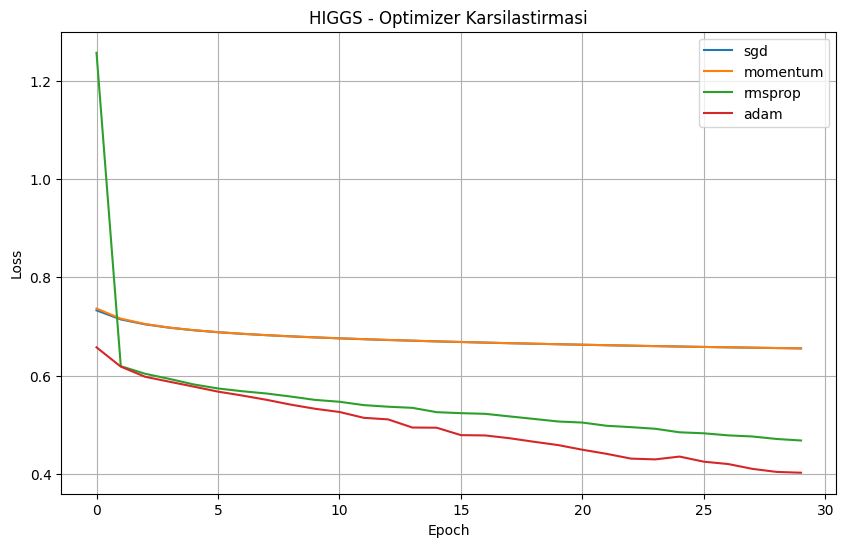


Sonuç Özeti:
sgd: 0.61
momentum: 0.6115
rmsprop: 0.68
adam: 0.6388


In [35]:
#  HIGGS - Optimizer Karşılaştırması
print("=" * 60)
print("HIGGS - OPTIMIZER KARŞILAŞTIRMASI")
print("=" * 60)

optimizer_listesi = ['sgd', 'momentum', 'rmsprop', 'adam']
optimizer_sonuclari = {}

for opt in optimizer_listesi:
    print("\n--- " + opt.upper() + " ---")
    
    # Model oluştur
    model = MLP(
        input_boyut=28,
        hidden1_boyut=64,
        hidden2_boyut=32,
        aktivasyon='relu',
        optimizer=opt,
        lr=0.01
    )
    
    # Eğit
    model.egit(X_train_h, y_train_h, epochs=30, batch_size=256, verbose=False)
    
    # Test et
    y_pred = model. tahmin_et(X_test_higgs)
    acc = accuracy_score(y_test_higgs, y_pred)
    
    optimizer_sonuclari[opt] = {
        'loss':  model.loss_gecmisi,
        'accuracy': acc
    }
    
    print("Test Accuracy: " + str(round(acc, 4)))

# Grafik çiz
plt.figure(figsize=(10, 6))
for opt in optimizer_listesi: 
    plt.plot(optimizer_sonuclari[opt]['loss'], label=opt)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('HIGGS - Optimizer Karsilastirmasi')
plt.legend()
plt.grid(True)
plt.show()

print("\nSonuç Özeti:")
for opt in optimizer_listesi: 
    print(opt + ": " + str(round(optimizer_sonuclari[opt]['accuracy'], 4)))

HIGGS - AKTİVASYON KARŞILAŞTIRMASI

--- SIGMOID ---
Test Accuracy: 0.6775

--- TANH ---
Test Accuracy: 0.6332

--- RELU ---
Test Accuracy: 0.6388


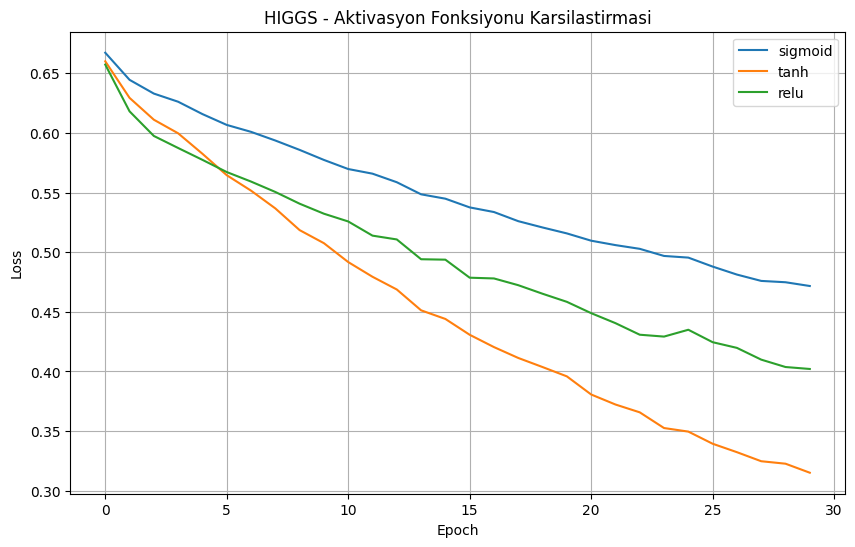


Sonuç Özeti:
sigmoid:  0.6775
tanh:  0.6332
relu:  0.6388


In [36]:
#  HIGGS - Aktivasyon Karşılaştırması
print("=" * 60)
print("HIGGS - AKTİVASYON KARŞILAŞTIRMASI")
print("=" * 60)

aktivasyon_listesi = ['sigmoid', 'tanh', 'relu']
aktivasyon_sonuclari = {}

for akt in aktivasyon_listesi:
    print("\n--- " + akt.upper() + " ---")
    
    model = MLP(
        input_boyut=28,
        hidden1_boyut=64,
        hidden2_boyut=32,
        aktivasyon=akt,
        optimizer='adam',
        lr=0.01
    )
    
    model.egit(X_train_h, y_train_h, epochs=30, batch_size=256, verbose=False)
    
    y_pred = model.tahmin_et(X_test_higgs)
    acc = accuracy_score(y_test_higgs, y_pred)
    
    aktivasyon_sonuclari[akt] = {
        'loss': model.loss_gecmisi,
        'accuracy':  acc
    }
    
    print("Test Accuracy: " + str(round(acc, 4)))

# Grafik çiz
plt. figure(figsize=(10, 6))
for akt in aktivasyon_listesi:
    plt.plot(aktivasyon_sonuclari[akt]['loss'], label=akt)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('HIGGS - Aktivasyon Fonksiyonu Karsilastirmasi')
plt.legend()
plt.grid(True)
plt.show()

print("\nSonuç Özeti:")
for akt in aktivasyon_listesi:
    print(akt + ":  " + str(round(aktivasyon_sonuclari[akt]['accuracy'], 4)))

HIGGS - LEARNING RATE ANALİZİ

--- LR = 0.1 ---
Test Accuracy: 0.6542

--- LR = 0.01 ---
Test Accuracy: 0.6388

--- LR = 0.001 ---
Test Accuracy: 0.6567


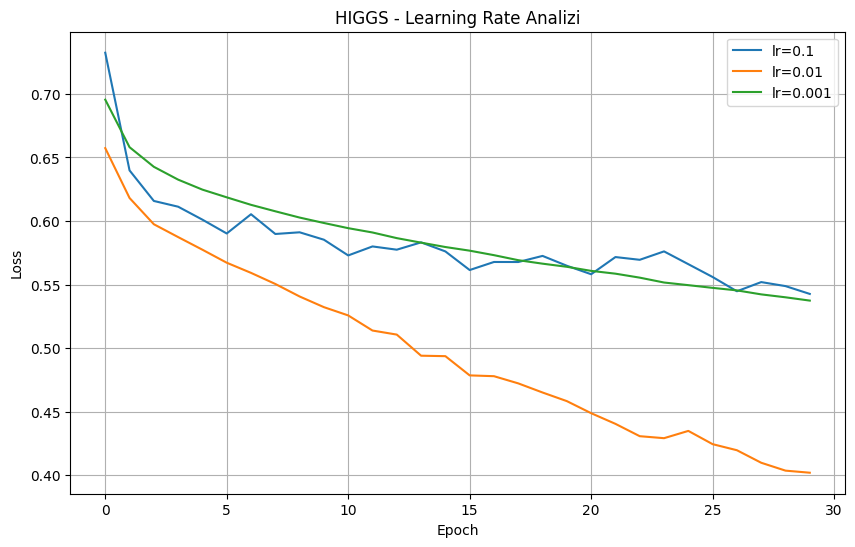

In [37]:
#  HIGGS - Learning Rate Analizi
print("=" * 60)
print("HIGGS - LEARNING RATE ANALİZİ")
print("=" * 60)

lr_listesi = [0.1, 0.01, 0.001]
lr_sonuclari = {}

for lr in lr_listesi:
    print("\n--- LR = " + str(lr) + " ---")
    
    model = MLP(
        input_boyut=28,
        hidden1_boyut=64,
        hidden2_boyut=32,
        aktivasyon='relu',
        optimizer='adam',
        lr=lr
    )
    
    model. egit(X_train_h, y_train_h, epochs=30, batch_size=256, verbose=False)
    
    y_pred = model.tahmin_et(X_test_higgs)
    acc = accuracy_score(y_test_higgs, y_pred)
    
    lr_sonuclari[lr] = {
        'loss':  model.loss_gecmisi,
        'accuracy': acc
    }
    
    print("Test Accuracy: " + str(round(acc, 4)))

# Grafik çiz
plt.figure(figsize=(10, 6))
for lr in lr_listesi:
    plt.plot(lr_sonuclari[lr]['loss'], label='lr=' + str(lr))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('HIGGS - Learning Rate Analizi')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
#  HIGGS - En İyi MLP
print("=" * 60)
print("HIGGS - EN İYİ MLP MODELİ")
print("=" * 60)

mlp_higgs = MLP(
    input_boyut=28,
    hidden1_boyut=64,
    hidden2_boyut=32,
    aktivasyon='relu',
    optimizer='adam',
    lr=0.01
)

mlp_higgs.egit(X_train_h, y_train_h, epochs=50, batch_size=256, verbose=True)

# Test değerlendirmesi
y_pred_mlp = mlp_higgs.tahmin_et(X_test_higgs)
acc_mlp = accuracy_score(y_test_higgs, y_pred_mlp)
f1_mlp = f1_score(y_test_higgs, y_pred_mlp)

print("\n--- MLP Sonuçları ---")
print("Accuracy: " + str(round(acc_mlp, 4)))
print("F1-Score: " + str(round(f1_mlp, 4)))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_higgs, y_pred_mlp))

HIGGS - EN İYİ MLP MODELİ
Epoch 1/50 - Loss: 0.6573
Epoch 6/50 - Loss: 0.5672
Epoch 11/50 - Loss: 0.5258
Epoch 16/50 - Loss: 0.4786
Epoch 21/50 - Loss: 0.4489
Epoch 26/50 - Loss: 0.4245
Epoch 31/50 - Loss: 0.392
Epoch 36/50 - Loss: 0.3806
Epoch 41/50 - Loss: 0.3518
Epoch 46/50 - Loss: 0.3437
Epoch 50/50 - Loss: 0.3277

--- MLP Sonuçları ---
Accuracy: 0.6455
F1-Score: 0.6708

Confusion Matrix:
[[1137  759]
 [ 659 1445]]


In [39]:
#  HIGGS - SVM (Pegasos)
print("=" * 60)
print("HIGGS - SVM (PEGASOS)")
print("=" * 60)

svm_higgs = PegasosSVM(
    lambda_param=0.0001,
    epochs=15,
    batch_size=512
)

svm_higgs.egit(X_train_h, y_train_h, verbose=True)

# Test değerlendirmesi
y_pred_svm = svm_higgs. tahmin_et(X_test_higgs)
acc_svm = accuracy_score(y_test_higgs, y_pred_svm)
f1_svm = f1_score(y_test_higgs, y_pred_svm)

print("\n--- SVM Sonuçları ---")
print("Accuracy: " + str(round(acc_svm, 4)))
print("F1-Score: " + str(round(f1_svm, 4)))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_higgs, y_pred_svm))

HIGGS - SVM (PEGASOS)
Epoch 1/15 - Accuracy:  0.5509
Epoch 2/15 - Accuracy:  0.5112
Epoch 3/15 - Accuracy:  0.5784
Epoch 4/15 - Accuracy:  0.5192
Epoch 5/15 - Accuracy:  0.5741
Epoch 6/15 - Accuracy:  0.5381
Epoch 7/15 - Accuracy:  0.568
Epoch 8/15 - Accuracy:  0.5305
Epoch 9/15 - Accuracy:  0.5772
Epoch 10/15 - Accuracy:  0.5348
Epoch 11/15 - Accuracy:  0.5834
Epoch 12/15 - Accuracy:  0.5715
Epoch 13/15 - Accuracy:  0.5796
Epoch 14/15 - Accuracy:  0.5774
Epoch 15/15 - Accuracy:  0.5813

--- SVM Sonuçları ---
Accuracy: 0.592
F1-Score: 0.6631

Confusion Matrix:
[[ 762 1134]
 [ 498 1606]]


In [17]:
#  HIGGS - Model Stacking
print("=" * 60)
print("HIGGS - MODEL STACKING (HİBRİT)")
print("=" * 60)

# MLP ve SVM'i validation seti üzerinde eğit
print("\n1. MLP eğitiliyor...")
mlp_stack = MLP(28, 64, 32, 'relu', 'adam', 0.01)
mlp_stack.egit(X_train_h, y_train_h, epochs=30, batch_size=256, verbose=False)

print("2. SVM eğitiliyor...")
svm_stack = PegasosSVM(0.0001, 10, 512)
svm_stack. egit(X_train_h, y_train_h, verbose=False)

# Validation seti üzerinde tahminler al
print("3. Meta-özellikler oluşturuluyor...")
mlp_val_pred = mlp_stack.olasilik_tahmin(X_val_h).ravel()
svm_val_skor = svm_stack.skor_hesapla(X_val_h)
svm_val_pred = 1.0 / (1.0 + np.exp(-svm_val_skor))  # sigmoid uygula

# Meta-özellik matrisi
meta_train = np.column_stack([mlp_val_pred, svm_val_pred])

# Lojistik regresyon meta-modeli eğit
print("4. Meta-model eğitiliyor...")
meta_model = LogisticRegression(random_state=22, max_iter=1000)
meta_model.fit(meta_train, y_val_h. ravel())

# Test seti için meta-özellikler
mlp_test_pred = mlp_stack.olasilik_tahmin(X_test_higgs).ravel()
svm_test_skor = svm_stack.skor_hesapla(X_test_higgs)
svm_test_pred = 1.0 / (1.0 + np. exp(-svm_test_skor))

meta_test = np.column_stack([mlp_test_pred, svm_test_pred])

# Final tahmin
y_pred_stack = meta_model. predict(meta_test)
acc_stack = accuracy_score(y_test_higgs, y_pred_stack)
f1_stack = f1_score(y_test_higgs, y_pred_stack)

print("\n--- Stacking Sonuçları ---")
print("Accuracy:  " + str(round(acc_stack, 4)))
print("F1-Score: " + str(round(f1_stack, 4)))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_higgs, y_pred_stack))

HIGGS - MODEL STACKING (HİBRİT)

1. MLP eğitiliyor...
2. SVM eğitiliyor...
3. Meta-özellikler oluşturuluyor...
4. Meta-model eğitiliyor...

--- Stacking Sonuçları ---
Accuracy:  0.6492
F1-Score: 0.6758

Confusion Matrix:
[[1135  761]
 [ 642 1462]]


RCV1 - OPTIMIZER KARŞILAŞTIRMASI

--- SGD ---
Test Accuracy: 0.5765

--- MOMENTUM ---
Test Accuracy: 0.5685

--- RMSPROP ---
Test Accuracy: 0.9035

--- ADAM ---
Test Accuracy: 0.9185


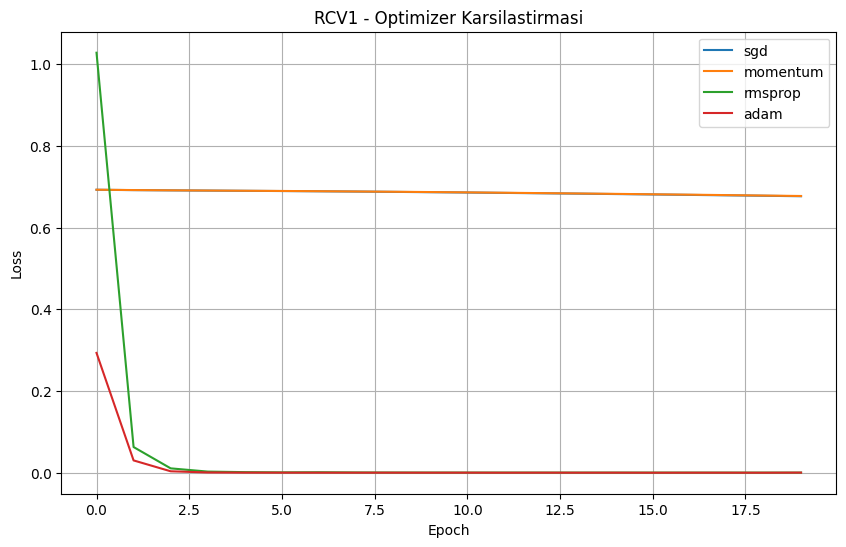

In [40]:
#  RCV1 - Optimizer Karşılaştırması
print("=" * 60)
print("RCV1 - OPTIMIZER KARŞILAŞTIRMASI")
print("=" * 60)

n_features = X_train_r.shape[1]
optimizer_sonuclari_rcv1 = {}

for opt in optimizer_listesi:
    print("\n--- " + opt.upper() + " ---")
    
    model = MLP(
        input_boyut=n_features,
        hidden1_boyut=128,
        hidden2_boyut=64,
        aktivasyon='relu',
        optimizer=opt,
        lr=0.01
    )
    
    model.egit(X_train_r, y_train_r, epochs=20, batch_size=128, verbose=False)
    
    y_pred = model. tahmin_et(X_test_rcv1)
    acc = accuracy_score(y_test_rcv1, y_pred)
    
    optimizer_sonuclari_rcv1[opt] = {
        'loss': model.loss_gecmisi,
        'accuracy':  acc
    }
    
    print("Test Accuracy: " + str(round(acc, 4)))

# Grafik çiz
plt. figure(figsize=(10, 6))
for opt in optimizer_listesi: 
    plt.plot(optimizer_sonuclari_rcv1[opt]['loss'], label=opt)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RCV1 - Optimizer Karsilastirmasi')
plt.legend()
plt.grid(True)
plt.show()

RCV1 - AKTİVASYON KARŞILAŞTIRMASI

--- SIGMOID ---
Test Accuracy: 0.92

--- TANH ---
Test Accuracy: 0.901

--- RELU ---
Test Accuracy: 0.91


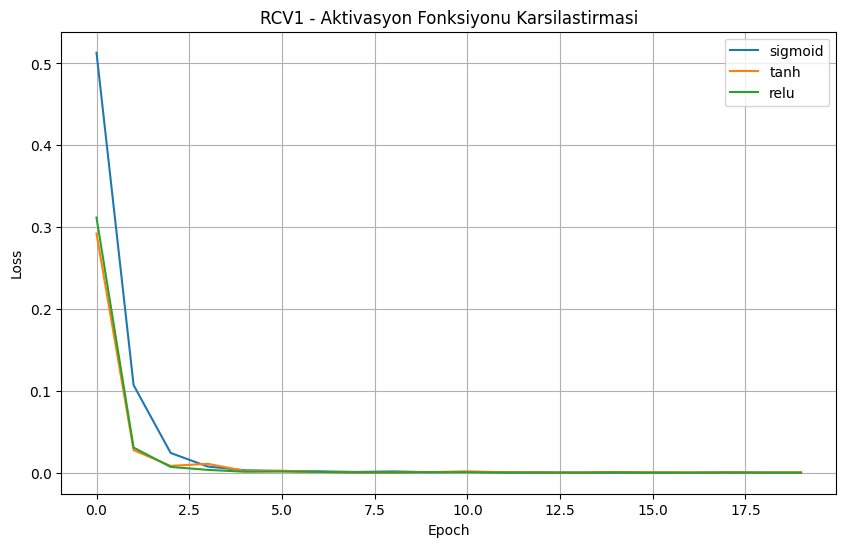

In [19]:
#  RCV1 - Aktivasyon Karşılaştırması
print("=" * 60)
print("RCV1 - AKTİVASYON KARŞILAŞTIRMASI")
print("=" * 60)

aktivasyon_sonuclari_rcv1 = {}

for akt in aktivasyon_listesi:
    print("\n--- " + akt.upper() + " ---")
    
    model = MLP(
        input_boyut=n_features,
        hidden1_boyut=128,
        hidden2_boyut=64,
        aktivasyon=akt,
        optimizer='adam',
        lr=0.01
    )
    
    model.egit(X_train_r, y_train_r, epochs=20, batch_size=128, verbose=False)
    
    y_pred = model.tahmin_et(X_test_rcv1)
    acc = accuracy_score(y_test_rcv1, y_pred)
    
    aktivasyon_sonuclari_rcv1[akt] = {
        'loss': model.loss_gecmisi,
        'accuracy': acc
    }
    
    print("Test Accuracy: " + str(round(acc, 4)))

# Grafik çiz
plt.figure(figsize=(10, 6))
for akt in aktivasyon_listesi:
    plt. plot(aktivasyon_sonuclari_rcv1[akt]['loss'], label=akt)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RCV1 - Aktivasyon Fonksiyonu Karsilastirmasi')
plt.legend()
plt.grid(True)
plt.show()

RCV1 - LEARNING RATE ANALİZİ

--- LR = 0.1 ---
Test Accuracy:  0.9

--- LR = 0.01 ---
Test Accuracy:  0.9185

--- LR = 0.001 ---
Test Accuracy:  0.9195


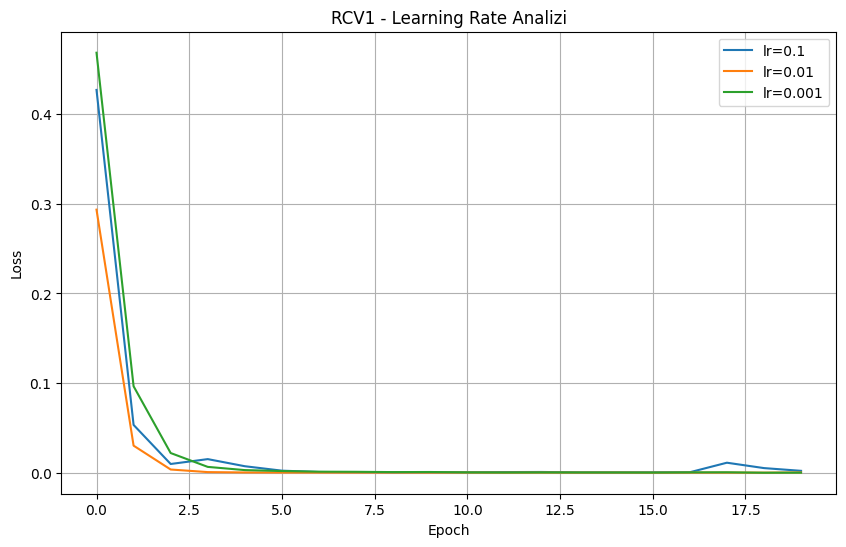

In [41]:
#  RCV1 - Learning Rate Analizi
print("=" * 60)
print("RCV1 - LEARNING RATE ANALİZİ")
print("=" * 60)

lr_sonuclari_rcv1 = {}

for lr in lr_listesi:
    print("\n--- LR = " + str(lr) + " ---")
    
    model = MLP(
        input_boyut=n_features,
        hidden1_boyut=128,
        hidden2_boyut=64,
        aktivasyon='relu',
        optimizer='adam',
        lr=lr
    )
    
    model.egit(X_train_r, y_train_r, epochs=20, batch_size=128, verbose=False)
    
    y_pred = model.tahmin_et(X_test_rcv1)
    acc = accuracy_score(y_test_rcv1, y_pred)
    
    lr_sonuclari_rcv1[lr] = {
        'loss': model. loss_gecmisi,
        'accuracy': acc
    }
    
    print("Test Accuracy:  " + str(round(acc, 4)))

# Grafik çiz
plt.figure(figsize=(10, 6))
for lr in lr_listesi: 
    plt.plot(lr_sonuclari_rcv1[lr]['loss'], label='lr=' + str(lr))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RCV1 - Learning Rate Analizi')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
#  RCV1 - En İyi MLP
print("=" * 60)
print("RCV1 - EN İYİ MLP MODELİ")
print("=" * 60)

mlp_rcv1 = MLP(
    input_boyut=n_features,
    hidden1_boyut=128,
    hidden2_boyut=64,
    aktivasyon='relu',
    optimizer='adam',
    lr=0.01
)

mlp_rcv1.egit(X_train_r, y_train_r, epochs=30, batch_size=128, verbose=True)

y_pred_mlp_r = mlp_rcv1.tahmin_et(X_test_rcv1)
acc_mlp_r = accuracy_score(y_test_rcv1, y_pred_mlp_r)
f1_mlp_r = f1_score(y_test_rcv1, y_pred_mlp_r)

print("\n--- MLP Sonuçları ---")
print("Accuracy: " + str(round(acc_mlp_r, 4)))
print("F1-Score:  " + str(round(f1_mlp_r, 4)))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_rcv1, y_pred_mlp_r))

RCV1 - EN İYİ MLP MODELİ
Epoch 1/30 - Loss: 0.2934
Epoch 6/30 - Loss: 0.0004
Epoch 11/30 - Loss: 0.0003
Epoch 16/30 - Loss: 0.0002
Epoch 21/30 - Loss: 0.0002
Epoch 26/30 - Loss: 0.0001
Epoch 30/30 - Loss: 0.0002

--- MLP Sonuçları ---
Accuracy: 0.919
F1-Score:  0.9121

Confusion Matrix:
[[998  55]
 [107 840]]


In [43]:
#  RCV1 - SVM (Pegasos)
print("=" * 60)
print("RCV1 - SVM (PEGASOS)")
print("=" * 60)

svm_rcv1 = PegasosSVM(
    lambda_param=0.0001,
    epochs=15,
    batch_size=256
)

svm_rcv1.egit(X_train_r, y_train_r, verbose=True)

y_pred_svm_r = svm_rcv1.tahmin_et(X_test_rcv1)
acc_svm_r = accuracy_score(y_test_rcv1, y_pred_svm_r)
f1_svm_r = f1_score(y_test_rcv1, y_pred_svm_r)

print("\n--- SVM Sonuçları ---")
print("Accuracy: " + str(round(acc_svm_r, 4)))
print("F1-Score: " + str(round(f1_svm_r, 4)))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_rcv1, y_pred_svm_r))

RCV1 - SVM (PEGASOS)
Epoch 1/15 - Accuracy:  0.4738
Epoch 2/15 - Accuracy:  0.5262
Epoch 3/15 - Accuracy:  0.6302
Epoch 4/15 - Accuracy:  0.5262
Epoch 5/15 - Accuracy:  0.4738
Epoch 6/15 - Accuracy:  0.5347
Epoch 7/15 - Accuracy:  0.5284
Epoch 8/15 - Accuracy:  0.6358
Epoch 9/15 - Accuracy:  0.5833
Epoch 10/15 - Accuracy:  0.7417
Epoch 11/15 - Accuracy:  0.5927
Epoch 12/15 - Accuracy:  0.7581
Epoch 13/15 - Accuracy:  0.6006
Epoch 14/15 - Accuracy:  0.5734
Epoch 15/15 - Accuracy:  0.7788

--- SVM Sonuçları ---
Accuracy: 0.746
F1-Score: 0.6345

Confusion Matrix:
[[1051    2]
 [ 506  441]]


In [44]:
#  RCV1 - Model Stacking
print("=" * 60)
print("RCV1 - MODEL STACKING (HİBRİT)")
print("=" * 60)

# MLP ve SVM eğit
print("\n1. MLP eğitiliyor...")
mlp_stack_r = MLP(n_features, 128, 64, 'relu', 'adam', 0.01)
mlp_stack_r. egit(X_train_r, y_train_r, epochs=20, batch_size=128, verbose=False)

print("2. SVM eğitiliyor...")
svm_stack_r = PegasosSVM(0.0001, 10, 256)
svm_stack_r.egit(X_train_r, y_train_r, verbose=False)

# Validation seti tahminleri
print("3. Meta-özellikler oluşturuluyor...")
mlp_val_pred_r = mlp_stack_r.olasilik_tahmin(X_val_r).ravel()
svm_val_skor_r = svm_stack_r.skor_hesapla(X_val_r)
svm_val_pred_r = 1.0 / (1.0 + np.exp(-svm_val_skor_r))

meta_train_r = np.column_stack([mlp_val_pred_r, svm_val_pred_r])

# Meta-model eğit
print("4. Meta-model eğitiliyor...")
meta_model_r = LogisticRegression(random_state=22, max_iter=1000)
meta_model_r.fit(meta_train_r, y_val_r.ravel())

# Test seti tahminleri
mlp_test_pred_r = mlp_stack_r. olasilik_tahmin(X_test_rcv1).ravel()
svm_test_skor_r = svm_stack_r.skor_hesapla(X_test_rcv1)
svm_test_pred_r = 1.0 / (1.0 + np.exp(-svm_test_skor_r))

meta_test_r = np.column_stack([mlp_test_pred_r, svm_test_pred_r])

# Final tahmin
y_pred_stack_r = meta_model_r.predict(meta_test_r)
acc_stack_r = accuracy_score(y_test_rcv1, y_pred_stack_r)
f1_stack_r = f1_score(y_test_rcv1, y_pred_stack_r)

print("\n--- Stacking Sonuçları ---")
print("Accuracy: " + str(round(acc_stack_r, 4)))
print("F1-Score: " + str(round(f1_stack_r, 4)))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_rcv1, y_pred_stack_r))

RCV1 - MODEL STACKING (HİBRİT)

1. MLP eğitiliyor...
2. SVM eğitiliyor...
3. Meta-özellikler oluşturuluyor...
4. Meta-model eğitiliyor...

--- Stacking Sonuçları ---
Accuracy: 0.921
F1-Score: 0.9149

Confusion Matrix:
[[993  60]
 [ 98 849]]
